In [0]:
from google.colab import drive
drive.mount('/content/drive/')

import os

os.chdir("/content/drive/My Drive/DM-HW4")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

import sys
from time import time

import numpy as np
import pandas as pd

# Explore the data set

In [0]:
data = pd.read_csv("lyrics.csv")

In [0]:
data.head()

index  ...                                             lyrics
0      0  ...  Oh baby, how you doing?\nYou know I'm gonna cu...
1      1  ...  playin' everything so easy,\nit's like you see...
2      2  ...  If you search\nFor tenderness\nIt isn't hard t...
3      3  ...  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...
4      4  ...  Party the people, the people the party it's po...

[5 rows x 6 columns]

## Artist can be useful feature

In [0]:
artist = data['artist'].value_counts()
print("length of artists", len(artist))
artist[:10]

length of artists 18231


dolly-parton        755
american-idol       700
elton-john          680
b-b-king            667
chris-brown         655
eddy-arnold         628
barbra-streisand    624
ella-fitzgerald     623
bob-dylan           614
bee-gees            599
Name: artist, dtype: int64

## Deal with NaN rows

I notice that there exists Nan in lyrics. I want to do following steps


1.   Statistics
2.   Delete Nan row

In [0]:
count_nan = len(data) - data.count()
print(count_nan)
print('----------------------------------')
print("Nan lyrics ratio {}".format(count_nan['lyrics']/len(data)))

index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64
----------------------------------
Nan lyrics ratio 0.264136463144295


In [0]:
# Step 2 Delete Nan row
print('size of original dataset', len(data))
data.dropna(subset=['lyrics'],inplace=True)
print('size of dataset without nan', len(data))

size of original dataset 362237
size of dataset without nan 266557


## Split dataset

I must split dataset before deal with unbalance dataset. Otherwise, when I oversampling dataset, I will add repetitions. As a result, my validation dataset and test dataset are not so valid.


In [0]:
# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)

# train= 80% | valid = 10% | test = 10%
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.1)
train = data.loc[:train_size,:]
val = data.loc[train_size:train_size + val_size , :]
test = data.loc[train_size + val_size:, :]


## Deal with unbalance dataset





In [0]:
train[train['genre']=='Metal']['lyrics']

33                                           (instrumental)
44        Reflecting ourselves in the blood of all the b...
48        Everything remained for behind me\nthe longing...
52        Witches been slaughtered at the stakes\nThey'v...
67                                           [instrumental]
                                ...                        
213204    I watched the sun again,\nIt's leaving now\nI'...
213208    (Music by Nergal, lyrics by Nergal)\n...With l...
213227    "Finally alone! - I want you so much!\nThe swe...
213240    Meine Art erscheint euch sonderbar\nEuch, die ...
213245                                        [intrumental]
Name: lyrics, Length: 19019, dtype: object

In [0]:
# explore the number of each genre
class_count = train['genre'].value_counts()
print(type(class_count))
class_count

<class 'pandas.core.series.Series'>


Rock             87398
Pop              32339
Hip-Hop          19872
Not Available    19178
Metal            19019
Country          11479
Jazz              6422
Electronic        6337
Other             4129
R&B               2726
Indie             2531
Folk              1816
Name: genre, dtype: int64

In [0]:
delete_attributes = ['Pop', 'Not Available','Metal','Country','Jazz','Electronic','Other','R&B','Indie','Folk']
dataset = [train,val,test]
for attr in delete_attributes:
    for sets in dataset:
        data_index = sets[sets['genre'] == attr].index
        sets.drop(data_index, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


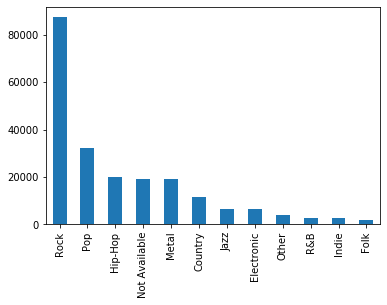

In [0]:
class_count.plot(kind='bar')

In [0]:
delete_index = train[train['genre'] == 'Rock'].index

In [0]:
type(delete_index)

pandas.core.indexes.numeric.Int64Index

In [0]:
delete_index[:10]

Int64Index([0, 2, 6, 9, 11, 12, 13, 15, 17, 20], dtype='int64')

In [0]:
#train.drop(delete_index[0:60000], inplace=True)

In [0]:
enhence_attributes = ['Hip-Hop']
for attr in enhence_attributes:
    tmp_data = train[train['genre'] == attr]
    for i in range(3):
        train = train.append(tmp_data)

In [0]:
#enhence_attributes = ['Jazz', 'Electronic','Other']
#for attr in enhence_attributes:
#    tmp_data = train[train['genre'] == attr]
#    for i in range(4):
#        train = train.append(tmp_data)

<class 'pandas.core.series.Series'>
Rock       87398
Hip-Hop    79488
Name: genre, dtype: int64


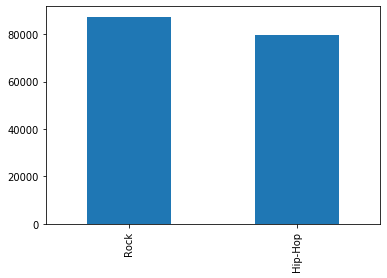

In [0]:
# explore the number of each genre
class_count = train['genre'].value_counts()
print(type(class_count))
print(class_count)
class_count.plot(kind='bar')

## Fraction

I start with a small dataset, 5% in order to build a pipline quickly.

In [0]:
# reset the index, otherwise, we will encounter errors 
#test.reset_index(drop=True, inplace=True)
#val.reset_index(drop=True, inplace=True)

#
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [0]:
ratio = 0.8
train_sample = train.loc[:int(len(train)*ratio),:]
val_sample = val.loc[:int(len(val)*ratio),:]
test_sample = test.loc[:int(len(test)*ratio),:]

print('size of train_sample', len(train_sample))
print('size of val_sample', len(val_sample))
print('size of test_sample', len(test_sample))

size of train_sample 133509
size of val_sample 10752
size of test_sample 10701


In [0]:
train

index  ...                                             lyrics
0       158233  ...  When I was a child,\nYou captured my devotion\...
1       226408  ...  Lyrics are not included\n----------------\nTyp...
3        75736  ...  I get my whiskey from a well, except on holida...
4       275566  ...  Well, if you're lookin' for the best\nBaby, be...
5       283952  ...  In the world of my subconscious, a realm of th...
...        ...  ...                                                ...
213241  247027  ...  Here I am\nAgain I spoke too soon\nIntentions ...
213242   49474  ...  No fun my babe no fun\nNo fun my babe no fun\n...
213243   14585  ...  (Hinkel / Freudenthaler)\nDo you know that bad...
213244  359377  ...  why are animals so abused?\nused as jackets, b...
213245    9811  ...  I was born in a beauty salon\nMy father was a ...

[170130 rows x 6 columns]

# In Summary

The code above is exploring the dataset. Here I put them together.



1.   Split dataset into train,val and test
2.   Remove rows containing Nan
3.  Delete Categories whose size are extremely small



size of original dataset 362237
size of dataset without nan 266557


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train size: 170130
Dev size: 21181
Test size: 21387
<class 'pandas.core.series.Series'>
Rock       87335
Pop        32408
Hip-Hop    19820
Metal      19025
Country    11542
Name: genre, dtype: int64


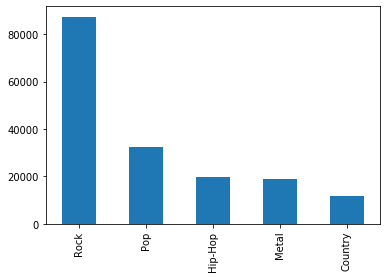

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

import sys
from time import time

import numpy as np
import pandas as pd

data = pd.read_csv("lyrics.csv")

print('size of original dataset', len(data))
data.dropna(subset=['lyrics'],inplace=True)
print('size of dataset without nan', len(data))

# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)

# train= 80% | valid = 10% | test = 10%
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.1)
train = data.loc[:train_size,:]
val = data.loc[train_size:train_size + val_size , :]
test = data.loc[train_size + val_size:, :]
                
delete_attributes = ['Not Available','Jazz','Electronic','Other','R&B','Indie','Folk']
dataset = [train,val,test]
for attr in delete_attributes:
    for sets in dataset:
        data_index = sets[sets['genre'] == attr].index
        sets.drop(data_index, inplace=True)

enhence_attributes=[]
#enhence_attributes = [('Hip-Hop',3),('Metal',3),('Country',5),('Pop',1)]
for attr,frac in enhence_attributes:
    tmp_data = train[train['genre'] == attr]
    for i in range(frac):
        train = train.append(tmp_data)

print("Train size:", len(train))
print("Dev size:", len(val))
print("Test size:", len(test))

# explore the number of each genre
class_count = train['genre'].value_counts()
print(type(class_count))
print(class_count)
class_count.plot(kind='bar')



1.   Balance dataset
2.   Feature Engineering
3.   Sample dataset



{'Pop': 0, 'Country': 1, 'Hip-Hop': 2, 'Rock': 3, 'Metal': 4}
sample_size 1154
1155
1155
1155
1155
1155
sample_size 137
138
138
138
138
138
sample_size 146
147
147
147
147
147
<class 'pandas.core.series.Series'>
Rock       1155
Metal      1155
Pop        1155
Hip-Hop    1155
Country    1155
Name: genre, dtype: int64
size of train_sample 5775
size of val_sample 690
size of test_sample 735


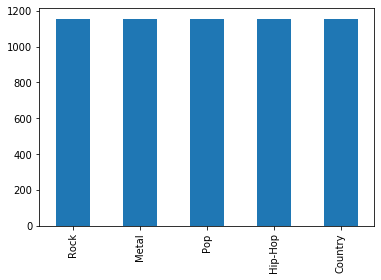

In [0]:
# reset the index, otherwise, we will encounter errors 
#test.reset_index(drop=True, inplace=True)
#val.reset_index(drop=True, inplace=True)
target_names = list(set(train['genre']))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

# shuffle
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
def feature_engineer(data,feature_list):
    for index, row in data.iterrows():
        for f in feature_list:
            data.loc[index,'lyrics'] = row[f] + ' ' + row['lyrics']



ratio = 0.1

enhence_attributes = [('Hip-Hop',3),('Metal',3),('Country',5),('Pop',1)]
def generate_sample_data(original_data,ratio):
    number = len(original_data)

    # deal with unbalanced dataset, keep the minimum size among each category.
    for label in target_names:
        tmp_data = original_data[original_data['genre'] == label]
        number = min(number, len(tmp_data))

    sample_size = int(number*ratio)
    print('sample_size',sample_size)
    sample_data = pd.DataFrame(columns=original_data.columns) 

    for label in target_names:
        tmp_data = original_data[original_data['genre'] == label].reset_index(drop=True)
        tmp_data = tmp_data.loc[:sample_size,:]
        sample_data = sample_data.append(tmp_data)
    return sample_data

train_sample = generate_sample_data(train, ratio)                      
val_sample = generate_sample_data(val, ratio)         
test_sample = generate_sample_data(test, ratio)         

# shuffle
train_sample = train_sample.sample(frac=1).reset_index(drop=True)
val_sample = val_sample.sample(frac=1).reset_index(drop=True)
test_sample = test_sample.sample(frac=1).reset_index(drop=True)

feature_engineer(train_sample,['artist'])
feature_engineer(val_sample,['artist'])
feature_engineer(test_sample,['artist'])

# explore the number of each genre
class_count = train_sample['genre'].value_counts()
print(type(class_count))
print(class_count)
class_count.plot(kind='bar')

print('size of train_sample', len(train_sample))
print('size of val_sample', len(val_sample))
print('size of test_sample', len(test_sample))

train_texts = train_sample['lyrics']
train_labels = train_sample['genre']

dev_texts = val_sample['lyrics']
dev_labels = val_sample['genre']

test_texts = test_sample['lyrics']
test_labels = test_sample['genre']

In [0]:
train_sample

index  ...                                             lyrics
0     154365  ...  don-moen All that I am, all that I have\nI lay...
1      76489  ...  downhere I'm giving up my electro TV things\n'...
2     257156  ...  chris-de-burgh And I saw a burning chariot,\nA...
3     211774  ...  gene-clark Stopped awhile this morning on my w...
4     265627  ...  cradle-of-filth Church bells resounded like ju...
...      ...  ...                                                ...
5770   40310  ...  ferlin-husky The chimes of time ring out the n...
5771  170602  ...  dion You better stop drinking that wine, sonny...
5772  357921  ...  andre-nickatina I take a flight with my niggaz...
5773  173395  ...  donna-fargo Shine on me sunshine\nWalk with me...
5774   53547  ...  amy-grant Children carry through the streets\n...

[5775 rows x 6 columns]

# Preprocessing

In [0]:
def clean_context(ctx_in, has_target=False):
            replace_newline = re.compile("\n")
            replace_dot = re.compile("\.")
            replace_cite = re.compile("'")
            replace_frac = re.compile("[\d]*frac[\d]+")
            replace_num = re.compile("\s\d+\s")
            rm_context_tag = re.compile('<.{0,1}context>')
            rm_cit_tag = re.compile('\[[eb]quo\]')
            rm_misc = re.compile("[\[\]\$`()%/,\.:;-]")

            ctx = replace_newline.sub(' ', ctx_in)  # (' <eop> ', ctx)

            ctx = replace_dot.sub(' ', ctx)  # .sub(' <eos> ', ctx)
            ctx = replace_cite.sub(' ', ctx)  # .sub(' <cite> ', ctx)
            ctx = replace_frac.sub(' <frac> ', ctx)
            ctx = replace_num.sub(' <number> ', ctx)
            ctx = rm_cit_tag.sub(' ', ctx)
            ctx = rm_context_tag.sub('', ctx)
            ctx = rm_misc.sub('', ctx)

            word_list = [word for word in re.split('`|, | +|\? |! |: |; |\(|\)|_|,|\.|"|“|”|\'|\'', ctx.lower()) if word]
            return word_list

def lemmatize_data(input_data):
    # input is a list of string
    result = []
    wnl = WordNetLemmatizer()
    for token in input_data:
        result.append(wnl.lemmatize(token))
    return result 


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


def preprocess(Corpus,attr='lyrics'):
    stop_words = set(stopwords.words('english'))
    # Remove blank rows if any.
    Corpus[attr].dropna(inplace=True)
    Corpus[attr] = [lemmatize_data(clean_context(entry)) for entry in Corpus[attr]]
    Corpus[attr] = [' '.join([token for token in entry if token not in stop_words]) for entry in Corpus[attr]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
preprocess(train_sample)
preprocess(val_sample)
preprocess(test_sample)

In [0]:
val_sample

index  ...                                             lyrics
0    171133  ...  eliyoungband heaven hell devil burned another ...
1    318449  ...  conniesmith easy come easy go found long time ...
2     44910  ...  chvrches never took side never cursed name kee...
3     46106  ...  bananarama come little bit closer whisper ear ...
4    334715  ...  fernandosorocaba ei vocãª que acha que eu sou ...
..      ...  ...                                                ...
685  267114  ...  bloodforblood well late think tripped gone ast...
686  270616  ...  billmonroe reach golden city golden city frien...
687  266877  ...  colbyodonis keep hand touchin every part aint ...
688  128638  ...  ashleytisdale last christmas gave heart next d...
689   67786  ...  eddyarnold sun wa hair sea wa eye voice wa war...

[690 rows x 6 columns]

## Encode label and tokens

### Build the dictionary

In [0]:
from collections import Counter
# Frequent count, keep the tokens above the threshold


count_words = Counter()

for words in train_sample['lyrics']:
    count_words.update(words.split(' '))

total_words = len(count_words)
sorted_words = count_words.most_common(total_words)

threshold = 10

print('original dictionaary size', total_words)
token_to_int = {}
token_to_int = {w:i+1 for i,(w,c) in enumerate(sorted_words) if c >= threshold}
token_to_int['PAD'] = 0

print('filtered dictionaary size', len(token_to_int))
token_to_int['UNK'] = len(token_to_int)

label_to_int = {}
for label in train['genre']:
    if label not in label_to_int:
        label_to_int[label] = len(label_to_int)

original dictionaary size 52861
filtered dictionaary size 6773


In [0]:
token_to_int['PAD']

0

### Encoding **function**

In [0]:
def encode(words,token_to_int):
    result = []
    for token in words.split(' '):
        if token not in token_to_int:
            result.append(token_to_int['UNK'])
        else:
            result.append(token_to_int[token])
    return result


In [0]:
datas = train_sample['lyrics'][0].split(' ')

In [0]:
token_to_int['hello']

717

In [0]:
int_to_token = {index:ele for index, ele in enumerate(token_to_int)}

In [0]:
# encode lyrics
train_sample['lyrics'] = [encode(words, token_to_int) for words in train_sample['lyrics']]
val_sample['lyrics'] = [encode(words, token_to_int) for words in val_sample['lyrics']]
test_sample['lyrics'] = [encode(words, token_to_int) for words in test_sample['lyrics']]

# encode labels
train_sample['genre'] = [label_to_int[label] for label in train_sample['genre']]
val_sample['genre'] = [label_to_int[label] for label in val_sample['genre']]
test_sample['genre'] = [label_to_int[label] for label in test_sample['genre']]


In [0]:
int_to_token[104]

'old'

In [0]:
#check
val_sample

index  ...                                             lyrics
0    171133  ...  [6773, 253, 205, 626, 1426, 113, 4800, 631, 44...
1    318449  ...  [3560, 348, 12, 348, 9, 229, 71, 8, 912, 647, ...
2     44910  ...  [6773, 14, 266, 146, 14, 2873, 131, 45, 423, 8...
3     46106  ...  [6773, 12, 54, 475, 1023, 1006, 720, 21, 109, ...
4    334715  ...  [6773, 5017, 2795, 61, 6773, 61, 1266, 2742, 6...
..      ...  ...                                                ...
685  267114  ...  [6773, 63, 289, 46, 6773, 74, 2666, 234, 52, 5...
686  270616  ...  [4795, 511, 922, 311, 922, 311, 108, 479, 7, 6...
687  266877  ...  [6773, 45, 66, 3463, 62, 312, 623, 167, 182, 2...
688  128638  ...  [6773, 111, 462, 337, 32, 275, 26, 337, 34, 18...
689   67786  ...  [2010, 155, 10, 502, 383, 10, 49, 395, 10, 797...

[690 rows x 6 columns]

## Padding

In [0]:
def pad_features(data, pad_length=100, left=True):
    features = [0 for i in range(pad_length)]

    num = min(len(data), pad_length)
    if left:
        features[:num] = data[:num]
    else:
        features[len(features)-num:] = data[:num]
    return features


In [0]:
# encode lyrics
pad_length = 100
train_sample['lyrics'] = [pad_features(words, pad_length) for words in train_sample['lyrics']]
val_sample['lyrics'] = [pad_features(words, pad_length) for words in val_sample['lyrics']]
test_sample['lyrics'] = [pad_features(words, pad_length) for words in test_sample['lyrics']]


## Convert to pytorch dataset

In [0]:
# config.py

class Config(object):
    embed_size = 300
    hidden_layers = 2
    hidden_size = 200
    bidirectional = True
    output_size = 5
    max_epochs = 300
    lr = 0.001
    batch_size = 100
    max_sen_len = 50 # Sequence length for RNN
    dropout_keep = 0.9

In [0]:
import torch 
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(torch.tensor(train_sample['lyrics']),
                           torch.tensor(train_sample['genre']))

val_data = TensorDataset(torch.tensor(val_sample['lyrics']),
                           torch.tensor(val_sample['genre']))

test_data = TensorDataset(torch.tensor(test_sample['lyrics']),
                           torch.tensor(test_sample['genre']))
config = Config
batch_size = config.batch_size

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True) 
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [0]:
# obtain one batch of training data 
dataiter = iter(train_loader) 
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x) 
print() 
print('Sample label size: ', sample_y.size()) # batch_size 
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([100, 100])
Sample input: 
 tensor([[6773,  383,   75,  ...,    0,    0,    0],
        [6773,  126,  235,  ...,    0,    0,    0],
        [6773,   32, 2431,  ...,   49, 3654, 1047],
        ...,
        [6773, 1384, 3460,  ...,   11, 5515, 1426],
        [6773,  303,  303,  ...,  303,    2,  303],
        [6773,   51, 1346,  ...,  395,  523,  152]])

Sample label size:  torch.Size([100])
Sample label: 
 tensor([0, 3, 1, 3, 1, 1, 3, 0, 1, 4, 4, 3, 1, 2, 0, 0, 3, 4, 2, 3, 2, 3, 4, 0,
        4, 4, 3, 3, 2, 2, 2, 4, 2, 2, 1, 1, 0, 2, 1, 0, 3, 4, 1, 0, 3, 0, 2, 4,
        3, 0, 1, 3, 2, 0, 2, 0, 4, 4, 4, 2, 0, 3, 3, 1, 0, 1, 3, 2, 3, 0, 1, 1,
        0, 3, 0, 0, 1, 1, 2, 4, 1, 0, 0, 4, 2, 2, 0, 0, 2, 1, 2, 3, 0, 2, 1, 4,
        2, 3, 1, 1])


# Model

## Build Model

In [0]:
def evaluate_model(model, iterator):
    all_preds = []
    all_y = []
    for idx,batch in enumerate(iterator):
        if torch.cuda.is_available():
            x = batch[0].cuda()
        else:
            x = batch[0]
        y_pred = model(x)
        y_pred = abs(y_pred)

        predicted = torch.argmax(y_pred.cpu().data, dim=1)
        #print(y_pred, predicted)
        all_preds.extend(predicted.numpy())
        all_y.extend(batch[1].numpy())
    score = accuracy_score(all_y, np.array(all_preds).flatten())
    return score

In [0]:
# model.py

import torch
from torch import nn
import numpy as np

class TextRNN(nn.Module):
    def __init__(self, config, vocab_size, word_embeddings):
        super(TextRNN, self).__init__()
        self.config = config
        
        # Embedding Layer
        self.embeddings = nn.Embedding(vocab_size, self.config.embed_size)
        self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
        
        self.lstm = nn.LSTM(input_size = self.config.embed_size,
                            hidden_size = self.config.hidden_size,
                            num_layers = self.config.hidden_layers,
                            dropout = self.config.dropout_keep,
                            batch_first=True)
        
        #self.dropout = nn.Dropout(self.config.dropout_keep)
        
       
        
        # dropout layer
        self.dropout = nn.Dropout(0.5)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(self.config.hidden_size, self.config.output_size)
        #self.sig = nn.Softmax(dim=1)
        

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embeddings(x)
        #hidden = self.init_hidden(batch_size)

        lstm_out, hidden = self.lstm(embeds)

        #print('final_cell_state lstm_out shape', lstm_out.shape)
        # stack up lstm outputs
        lstm_out = lstm_out[:, -1,:].squeeze()
        #lstm_out = lstm_out.contiguous().view(-1, self.config.hidden_size)
        #print('lstm_out', lstm_out.shape)
        #print('hidden', hidden)
        # dropout and fully-connected layer
        #lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out)
        # sigmoid function
        #sig_out = self.sig(out)
        
        # reshape to be batch_size first
        #sig_out = sig_out.view(batch_size, -1)
        #sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return out    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(batch_size,self.config.hidden_layers, self.config.hidden_size)
        return hidden
    
    def add_optimizer(self, optimizer):
        self.optimizer = optimizer
        
    def add_loss_op(self, loss_op):
        self.loss_op = loss_op
    
    def reduce_lr(self):
        print("Reducing LR")
        for g in self.optimizer.param_groups:
            g['lr'] = g['lr'] / 2
                
    def run_epoch(self, train_iterator, val_iterator, epoch):
        train_losses = []
        val_accuracies = []
        losses = []
        
        # Reduce learning rate as number of epochs increase
        if (epoch == int(self.config.max_epochs/3)) or (epoch == int(2*self.config.max_epochs/3)):
            self.reduce_lr()
            
        for i, batch in enumerate(train_iterator):
            self.optimizer.zero_grad()
            if torch.cuda.is_available():
                x = batch[0].cuda()
                y = batch[1].type(torch.cuda.LongTensor)
            else:
                x = batch[0]
                y = batch[1].type(torch.LongTensor)

            y_pred = self.__call__(x)
            #print(y_pred, y)
            loss = self.loss_op(y_pred, y)
            #print(loss)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
    
            if i % 500 == 0:
                #writer.add_scalar('training loss',
                 #           sum(losses) / 1000,
                  #          epoch * len(train_iterator) + i)

                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                #writer.add_figure('predictions vs. actuals',
                 #           plot_classes_preds(net, inputs, labels),
                  #          global_step=epoch * len(train_iterator) + i)
                print("Iter: {}".format(i+1))
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                print("\tAverage training loss: {:.5f}".format(avg_train_loss))
                losses = []
                
                # Evalute Accuracy on validation set
                val_accuracy = evaluate_model(self, val_iterator)
                print("\tVal Accuracy: {:.4f}".format(val_accuracy))
                self.train()
                
        return train_losses, val_accuracy

## Load Embedding

In [0]:

import numpy as np


def load_glove(path=None, dim=None, size=None):   # download from https://nlp.stanford.edu/projects/glove/
    if path is None:
        if size=='6B':
            path = data_dir + 'glove.6B/glove.6B.' + str(dim) + 'd.txt'
        elif size=='42B' and dim==300:
            path = data_dir+'glove.42B.300d.txt'
        elif size=='840B' and dim==300:
            path = data_dir+'glove.840B.300d.txt'
        else:
            print(u'No pre-trained word-embeddings at dir:%s' % (data_dir))
            exit(-3)

    wordvecs = {}
    with open(path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            tokens = line.split(' ')
            vec = np.array(tokens[1:], dtype=np.float32)
            wordvecs[tokens[0]] = vec

    return wordvecs


def fill_with_gloves(word_to_id, path=None, emb_size=None, vocab_size=None, wordvecs=None):
    if not wordvecs:
        wordvecs = load_glove(path, emb_size, vocab_size)

    n_words = len(word_to_id)

    if emb_size is None:
        emb_size = len(wordvecs[list(wordvecs.keys())[0]])

    res = np.zeros([n_words, emb_size], dtype=np.float32)
    n_not_found = 0
    words_notin = set()
    for word, id in word_to_id.items():
        if '#' in word:
            word = word.split('#')[0]   # Remove pos tag
        
        # maybe trained embedding containes n-gram embeddding
        if word in wordvecs:
            words = [word]
        elif '-' in word:
            words = word.split('-')
        elif '_' in word:
            words = word.split('_')
        else:
            words = [word]

        vecs = []
        for w in words:
            if w in wordvecs:
                vecs.append(wordvecs[w])    # add word2vec for multi-word
                
        if vecs != []:
            res[id, :] = np.mean(np.array(vecs), 0)
        else:
            words_notin.add(word)
            n_not_found += 1
            res[id, :] = np.random.normal(0.0, 0.1, emb_size)
    print( 'n words not found in glove word vectors: ' + str(n_not_found))
#    if words_notin:
#        open('../tmp/word_not_in_glove.txt','w').write((u'\n'.join(words_notin)).encode('utf-8'))

    return res




In [0]:
res = fill_with_gloves(token_to_int, path='./glove.6B.300d.txt', emb_size=300, vocab_size='6B', wordvecs=None)
res.shape

n words not found in glove word vectors: 428


(6774, 300)

## Training

In [0]:
CUDA_LAUNCH_BLOCKING=1

In [0]:
# train.py

import sys
import torch.optim as optim
from torch import nn
import torch

if __name__=='__main__':
    
    config = Config()
    # Create Model with specified optimizer and loss function
    ##############################################################
    model = TextRNN(config, len(token_to_int), torch.from_numpy(res))
    if torch.cuda.is_available():
        model.cuda()
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    NLLLoss = torch.nn.CrossEntropyLoss()
    model.add_optimizer(optimizer)
    model.add_loss_op(NLLLoss)
    ##############################################################
    
    train_losses = []
    val_accuracies = []
    
    for i in range(config.max_epochs):
        print ("Epoch: {}".format(i))
        train_loss,val_accuracy = model.run_epoch(train_loader, valid_loader, i)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)

    train_acc = evaluate_model(model, train_loader)
    val_acc = evaluate_model(model, valid_loader)
    test_acc = evaluate_model(model, test_loader)

    print ('Final Training Accuracy: {:.4f}'.format(train_acc))
    print ('Final Validation Accuracy: {:.4f}'.format(val_acc))
    print ('Final Test Accuracy: {:.4f}'.format(test_acc))

Epoch: 0
Iter: 1
	Average training loss: 1.61530
	Val Accuracy: 0.2000
Epoch: 1
Iter: 1
	Average training loss: 1.47155
	Val Accuracy: 0.2167
Epoch: 2
Iter: 1
	Average training loss: 1.39218
	Val Accuracy: 0.1750
Epoch: 3
Iter: 1
	Average training loss: 1.29576
	Val Accuracy: 0.2667
Epoch: 4
Iter: 1
	Average training loss: 1.37035
	Val Accuracy: 0.2033
Epoch: 5
Iter: 1
	Average training loss: 1.53971
	Val Accuracy: 0.2050
Epoch: 6
Iter: 1
	Average training loss: 1.41783
	Val Accuracy: 0.2000
Epoch: 7
Iter: 1
	Average training loss: 1.54397
	Val Accuracy: 0.2033
Epoch: 8
Iter: 1
	Average training loss: 1.44771
	Val Accuracy: 0.1967
Epoch: 9
Iter: 1
	Average training loss: 1.36290
	Val Accuracy: 0.1883
Epoch: 10
Iter: 1
	Average training loss: 1.26160
	Val Accuracy: 0.1900
Epoch: 11
Iter: 1
	Average training loss: 1.29548
	Val Accuracy: 0.2583
Epoch: 12
Iter: 1
	Average training loss: 1.32695
	Val Accuracy: 0.2517
Epoch: 13
Iter: 1
	Average training loss: 1.17602
	Val Accuracy: 0.3033
Ep

KeyboardInterrupt: ignored